In [1]:
import os
%load_ext autoreload
%autoreload 2
from ssd import ssd_preds
import cv2
import json
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

Ensure that the backend server is running using:
```python project\backend\model_inference\model_inference_app.py```

In [15]:
# validation_dataset = "C:/Users/julian/Downloads/validation"
validation_dataset = "../../../images/validation/"

In [9]:
image_path = 'C:/Users/julian/Downloads/validation\Recyclable\R_993.jpg'
img = cv2.imread(image_path)
pil_image = Image.fromarray(img)
results = ssd_preds([pil_image], 'efficientnet_v2_l')
print(json.dumps(results, indent=2))

[
  {
    "object_class": "Other plastic bottle",
    "object_class_probs": [
      0.27272486686706543,
      0.20217618346214294,
      0.10821132361888885,
      0.09578986465930939,
      0.09394338726997375,
      0.06147213280200958,
      0.05748726800084114,
      0.03758174553513527,
      0.037049513310194016,
      0.03356369957327843
    ],
    "object_classes": [
      "Other plastic bottle",
      "Polypropylene bag",
      "Clear plastic bottle",
      "Other plastic",
      "Foam food container",
      "Tupperware",
      "Other plastic container",
      "Single-use carrier bag",
      "Plastic glooves",
      "Other carton"
    ],
    "object_trash_class": "Garbage",
    "object_trash_class_probs": [
      0.25,
      0.25,
      0.25,
      0.25
    ],
    "trash_class": "Household hazardous waste",
    "trash_class_probs": [
      0.01702374964952469,
      0.1877964437007904,
      0.08119114488363266,
      0.7139886021614075
    ],
    "trash_classes": [
      "Ga

In [ ]:
labels = []
predicted_classes = []
model = 'efficientnet_v2_l'

# loop through the directory and its subdirectories
for root, dirs, files in os.walk(validation_dataset):
    for file in files:
        # check if the file extension is an image format
        if file.lower().endswith((".png", ".jpg", ".jpeg", ".bmp", ".gif")):
            # return the full path to the image file
            image_path = os.path.join(root, file)
            img = cv2.imread(image_path)
            pil_image = Image.fromarray(img)
            true_label = os.path.basename(root)
            
            results = ssd_preds([pil_image], model)[0]
            predicted_label = results['object_trash_class']
            object_class = results['object_class']
            # add the true label and predicted label to the lists
            labels.append(true_label)
            predicted_classes.append(predicted_label)
            if true_label != predicted_label:
                print(image_path)
                print(f'object_class: {object_class}')
                print(f"Prediction: {predicted_label}; True label: {true_label}")
                print()
            
    

../../../images/validation/Garbage\trash80.jpg
object_class: cup
Prediction: Recyclable; True label: Garbage

../../../images/validation/Garbage\trash87.jpg
object_class: pill bottle
Prediction: Recyclable; True label: Garbage

../../../images/validation/Household hazardous waste\479.jpg
object_class: window screen
Prediction: Garbage; True label: Household hazardous waste

../../../images/validation/Organic Waste\O_12334.jpg
object_class: coral reef
Prediction: Garbage; True label: Organic Waste

../../../images/validation/Organic Waste\O_13718.jpg
object_class: candle
Prediction: Garbage; True label: Organic Waste

../../../images/validation/Organic Waste\O_13720.jpg
object_class: maraca
Prediction: Garbage; True label: Organic Waste

../../../images/validation/Organic Waste\O_13831.jpg
object_class: soap dispenser
Prediction: Garbage; True label: Organic Waste

../../../images/validation/Organic Waste\O_13939.jpg
object_class: pot
Prediction: Garbage; True label: Organic Waste

../.

In [13]:
import numpy as np
from sklearn.preprocessing import label_binarize
from sklearn.metrics import average_precision_score

from sklearn.preprocessing import LabelEncoder

# create a LabelEncoder object
le = LabelEncoder()
# fit the encoder to your labels and transform them
labels_encoded = le.fit_transform(labels)
# fit the encoder to your predicted classes and transform them
predicted_classes_encoded = le.transform(predicted_classes)

# convert the labels and predicted_classes lists to arrays
labels_encoded = np.array(labels_encoded)
predicted_classes_encoded = np.array(predicted_classes_encoded)

# binarize the labels and predicted_classes arrays
n_classes = len(set(labels_encoded))
labels_bin = label_binarize(labels_encoded, classes=range(n_classes))
predicted_classes_bin = label_binarize(predicted_classes_encoded, classes=range(n_classes))

# compute the average precision score for each class
average_precisions = []
for i in range(n_classes):
    average_precisions.append(average_precision_score(labels_bin[:, i], predicted_classes_bin[:, i]))

# compute the mean average precision score
mAP = np.mean(average_precisions)
print(f"Mean Average Precision: {mAP:.2f}")


Mean Average Precision: 0.84


C:\Users\julian\AppData\Local\Temp/ipykernel_11612/3172724690.py:6: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("Blues").copy()
  cmap.set_bad(color='black')


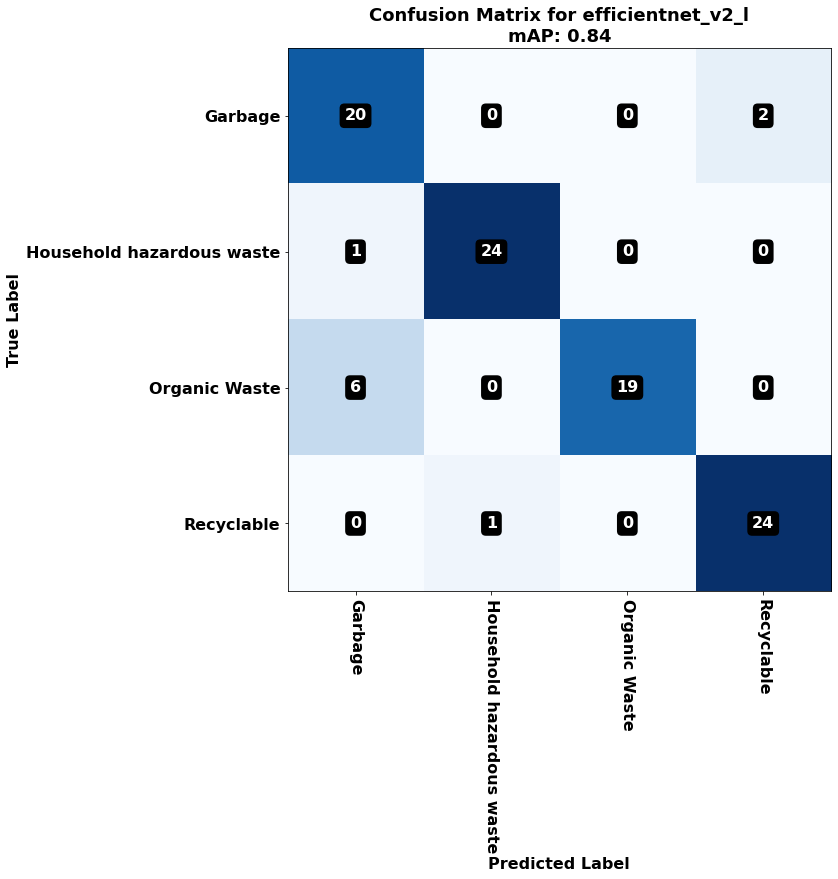

In [14]:
# compute the confusion matrix
confusion = confusion_matrix(labels, predicted_classes)

# plot the confusion matrix with custom color map
cmap = plt.cm.Blues
cmap.set_bad(color='black')
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(confusion, cmap=cmap)

# add labels and ticks to the plot
classes = sorted(set(labels))
ax.set_xticks(np.arange(len(classes)))
ax.set_yticks(np.arange(len(classes)))
ax.set_xticklabels(classes, fontsize=16, fontweight='bold', rotation=-90)
ax.set_yticklabels(classes, fontsize=16, fontweight='bold')
ax.set_xlabel('Predicted Label', fontsize=16, fontweight='bold')
ax.set_ylabel('True Label', fontsize=16, fontweight='bold')

# add the counts to the plot with better contrast
for i in range(len(classes)):
    for j in range(len(classes)):
        text = ax.text(j, i, confusion[i, j],
                       ha="center", va="center", color="w", fontsize=16, fontweight='bold',
                       bbox=dict(boxstyle='round', facecolor='black', edgecolor='none'))

# add a title to the plot
ax.set_title(f"Confusion Matrix for {model}\nmAP: {mAP:.2f}", fontsize=18, fontweight='bold')

# show the plot
plt.show()